# Рекомендация тарифов

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучние-полученных-данных" data-toc-modified-id="Изучние-полученных-данных-1">Изучние полученных данных</a></span></li><li><span><a href="#Разделение-данных-на-выборки" data-toc-modified-id="Разделение-данных-на-выборки-2">Разделение данных на выборки</a></span></li><li><span><a href="#Исследование-моделей" data-toc-modified-id="Исследование-моделей-3">Исследование моделей</a></span><ul class="toc-item"><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-3.1">Решающее дерево</a></span></li><li><span><a href="#Случайный-лес-решающих-деревьев" data-toc-modified-id="Случайный-лес-решающих-деревьев-3.2">Случайный лес решающих деревьев</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.3">Линейная регрессия</a></span></li></ul></li><li><span><a href="#Проверка-модели-на-тестовой-выборке" data-toc-modified-id="Проверка-модели-на-тестовой-выборке-4">Проверка модели на тестовой выборке</a></span></li><li><span><a href="#Проверка-модели-на-адекватность" data-toc-modified-id="Проверка-модели-на-адекватность-5">Проверка модели на адекватность</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6">Вывод</a></span></li></ul></div>

<h1>Описание проекта</h1>
В связи с оптимизацией архивных тарифов оператор связи «Мегалайн» планирует ввести систему рекомендации новых тарифов.
Для этого оператор предоставил исторические данные пользователей, уже перешедших на новые тарифы. На базе этих данных необходимо разработать модель классификации абонентов по тарифам с точностью(*accuracy*) не ниже 75%.

Ход проведения исследования:
1. Изучение пердоставленных данных
2. Подготовка обучающей, валидационной и тестовой выборок.
3. Сравнение разных моделей в зависимости от гиперпараметров.
4. Проверка качества выбранной модели.
5. Проверка модели на вменяемость.

## Изучние полученных данных

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from joblib import dump
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('https://___/datasets/users_behavior.csv')

In [ ]:
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Для исследования предоставлен файл с данными о активности пользоваателей за месяц:
- количество совершенных звонков (calls)
- суммарная продолжительность этих звонков (minutes)
- количество отправленных сообщений (messages)
- использованный интернет трафик (mb_used)
- тип тарифа Смарт/Ультра (is_ultra)

Как можем заметить, в данной таблице 3,2 тысячи строк, в которых нет пропусков. Значения в столбцах звонков и сообщений указаны в штуках, продолжительность - в минутах, трафик - в мегабайтах, а тип тарифа говорит о наличия тарифа "ультра" у пользователя(1) или "смарт"(0).

Рассмотрим подробнее, что ещё содержат данные. Есть ли связи между разными параметрами и тарифами.

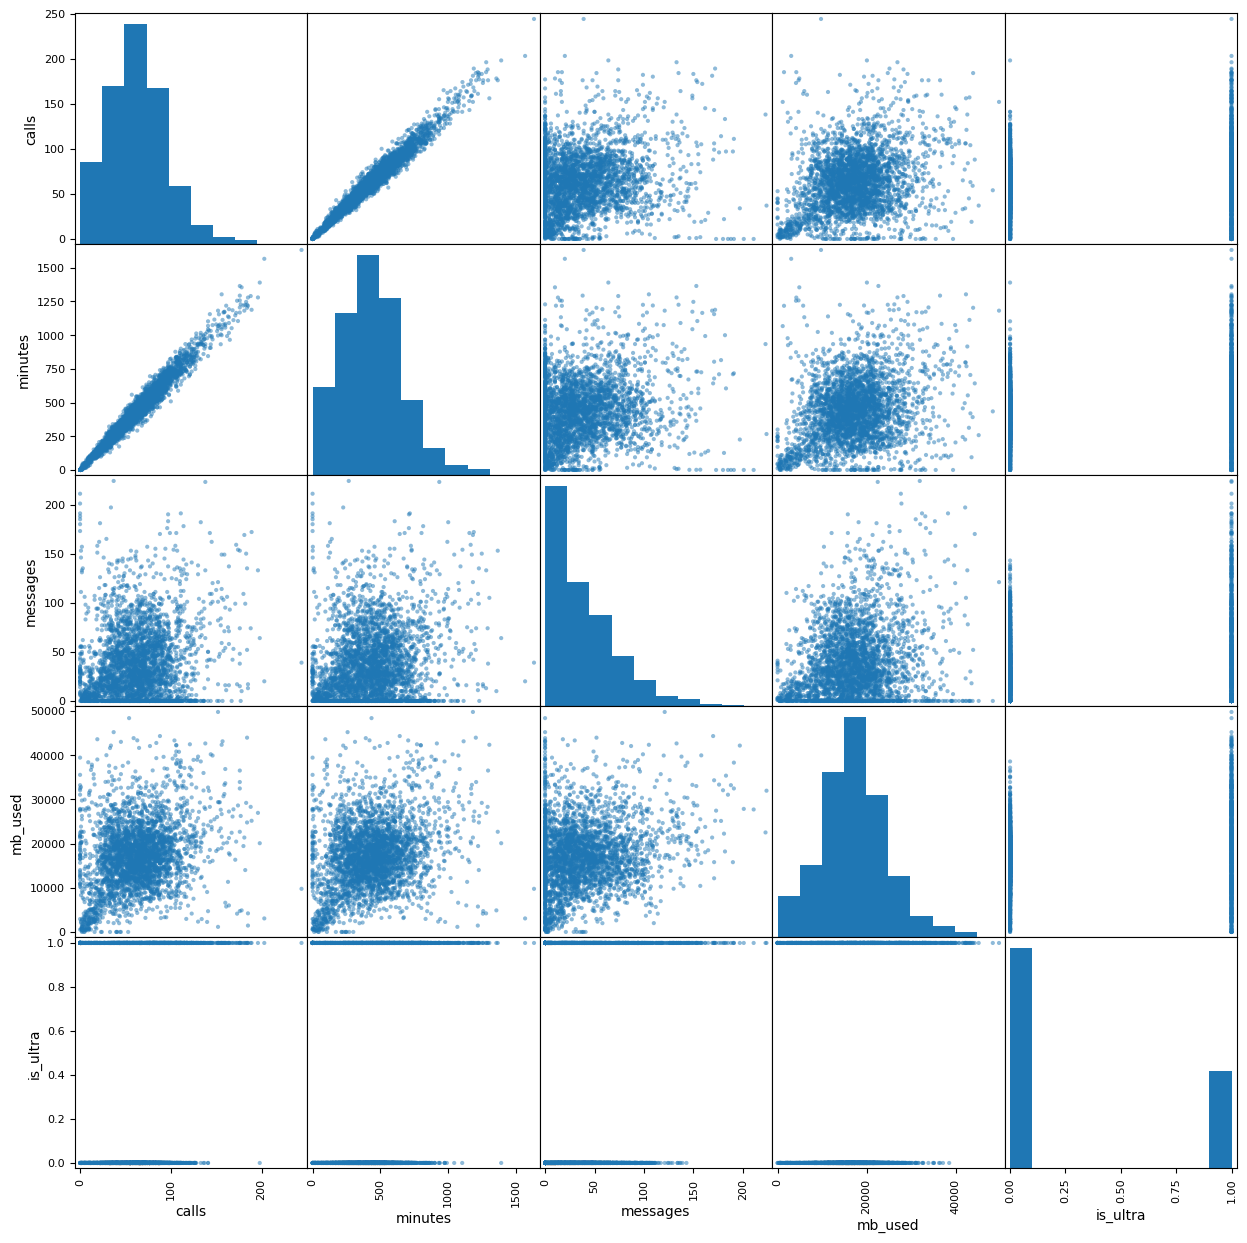

In [ ]:
pd.plotting.scatter_matrix(
    data,
    figsize=(15, 15))
plt.show()

На графиках видна сильная линейная положительная зависимость меежду количеством звонков и их суммарной продолжительностью. Ткаже видно, что графики количества звонков, минут, смс и трафика соответствуют распределению Пуассона. Пользователей тарифа Смарт больше, чем пользователей тарифа ультра. Посмотрим, как распределяются значения по тарифам.

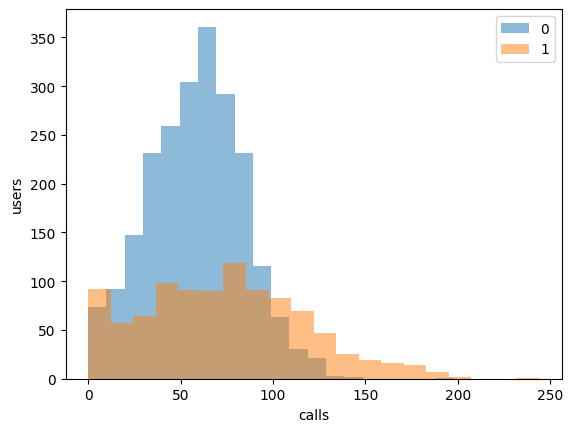

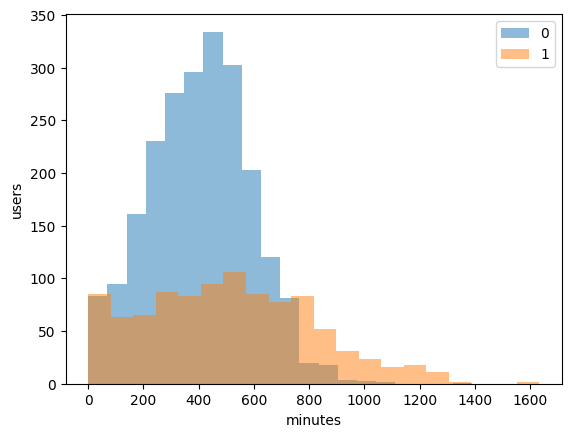

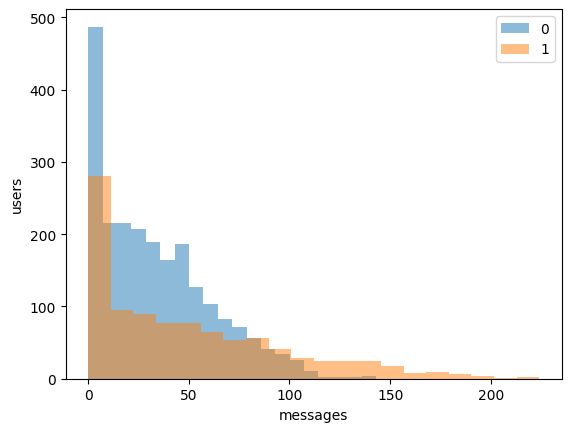

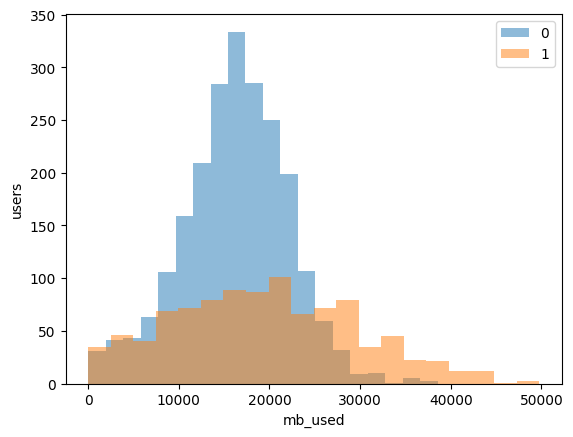

In [ ]:
for param in ['calls', 'minutes', 'messages', 'mb_used']:
    data.groupby('is_ultra')[param].plot(kind='hist', bins=20, alpha=0.5)
    plt.legend(['0', '1'])
    plt.xlabel(param)
    plt.ylabel('users')
    plt.show()

Пользователей тарифа смарт больше, чем пользователей тарифа ультра.
На графиках видно, что в обоих тарифах есть уникальные пользователи, которые используют значительно больше звонков, сообщений или трафика. Посмотрим, на сколько сильно они выбиваются, для этого построим графики ящик с усами для параметров каждого тарифа.

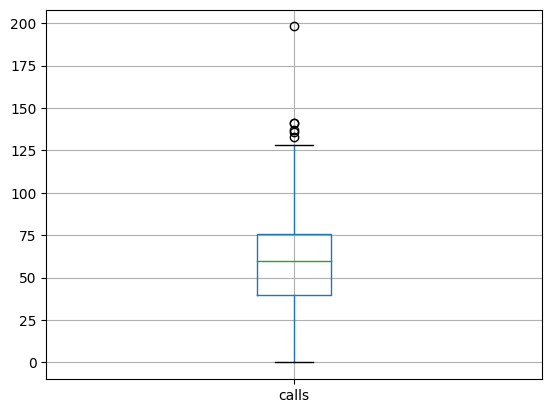

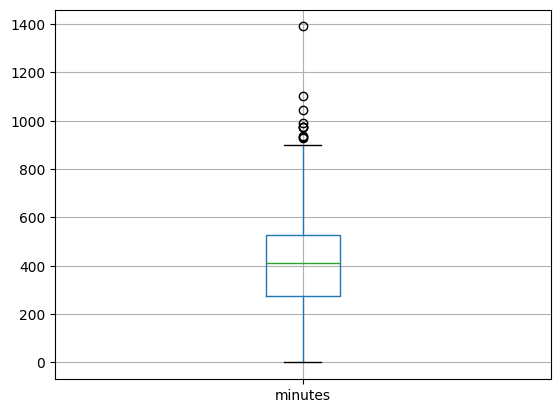

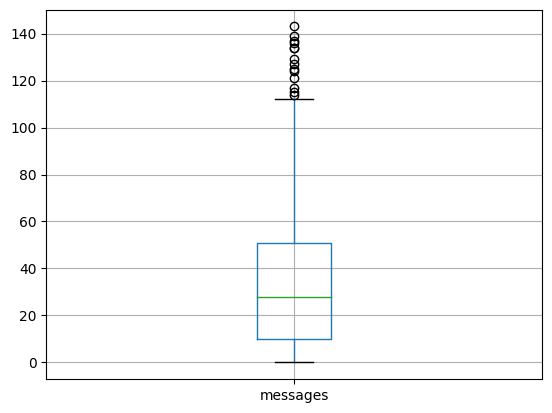

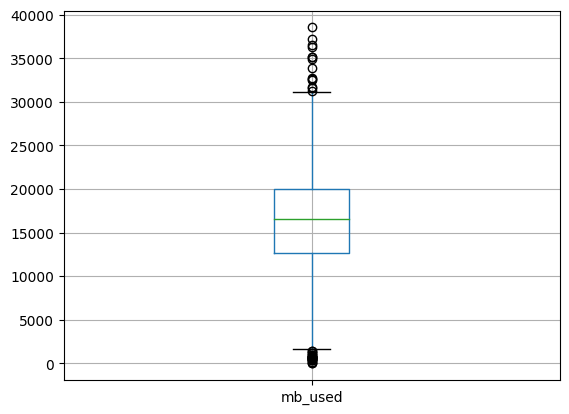

In [ ]:
# тариф Смарт
for param in ['calls', 'minutes', 'messages', 'mb_used']:
    data[data['is_ultra'] == 0].boxplot(column=param)
    plt.show()

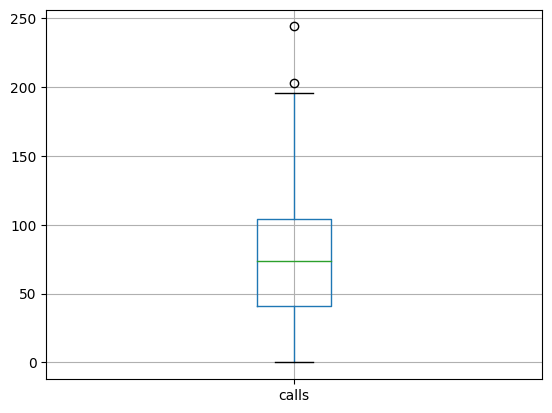

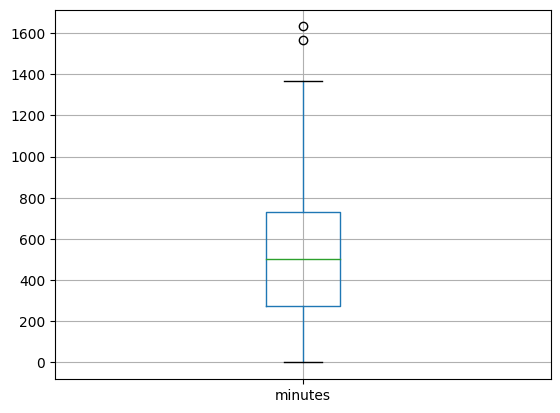

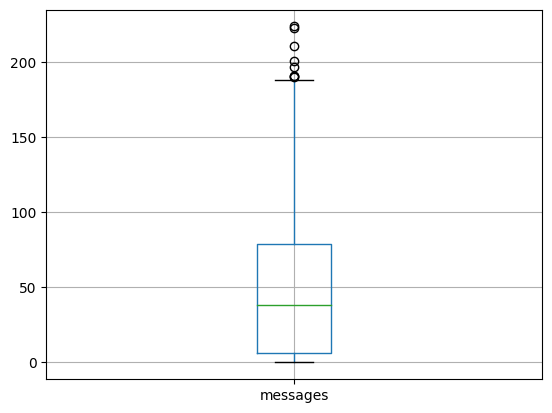

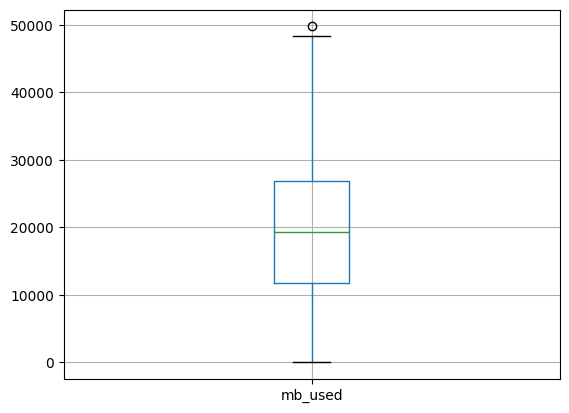

In [ ]:
# тариф Ультра
for param in ['calls', 'minutes', 'messages', 'mb_used']:
    data[data['is_ultra'] == 1].boxplot(column=param)
    plt.show()

Среди пользователей тарифа Смарт наблюдается больше аномалий, чем для пользователей тарифа Ультра.

Для пользователей тарифа Смарт характерно совершение до 125 завонков, общей продолжительностью до 900 минут, отправка до 110 сообщений и использование от 2,5 до 30 Гб трафика. Пользователи тарифа Ультра - до 200 звонков, продолжительностью до 1400 минут, до 190 сообщений и 48 Гб трафика.

## Разделение данных на выборки

Так как у нас нет отдельной валидационной выборки и спрятанной тестовой выборки, разделим общие данные на 3 части в следующих пропорциях: 60% - обучающие данные, 20% - валидацтонная выборка и 20% - тестовая выборка. Это стандартное разделение на выборки 3:1:1.

In [ ]:
# выделим обучающие данные
data_train, data_valid_and_test = train_test_split(data,
                                                   test_size=0.4,
                                                   random_state=12345)

In [ ]:
# разделим оставшиеся данные на вавлидационные и тестовые
data_valid, data_test = train_test_split(data_valid_and_test,
                                         test_size=0.5,
                                         random_state=12345)

Для большей точности модели очистим обучающую выборку от лишних выбросов.

In [ ]:
# исключение выбрасов в количестве звонков
data_train = data_train[
             ((data_train['is_ultra'] == 0) &
             (data_train['calls'] < 126)) |
             ((data_train['is_ultra'] == 1) &
             (data_train['calls'] < 200))
             ]

In [ ]:
# исключение выбросов в суммарной продолжительности звонков
data_train = data_train[
             ((data_train['is_ultra'] == 0) &
             (data_train['minutes'] < 900)) |
             ((data_train['is_ultra'] == 1) &
             (data_train['minutes'] < 1400))
             ]

In [ ]:
# исключение выбросов в количестве сообщений
data_train = data_train[
             ((data_train['is_ultra'] == 0) &
             (data_train['messages'] < 110)) |
             ((data_train['is_ultra'] == 1) &
             (data_train['messages'] < 190))
             ]

In [ ]:
# исключение выбросов в количестве использованного трафика
data_train = data_train[
             ((data_train['is_ultra'] == 0) &
             (data_train['mb_used'] > 2500)) |
             ((data_train['is_ultra'] == 0) &
             (data_train['mb_used'] < 30000)) |
             ((data_train['is_ultra'] == 1) &
             (data_train['mb_used'] < 48000))
             ]

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1903 entries, 3027 to 482
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     1903 non-null   float64
 1   minutes   1903 non-null   float64
 2   messages  1903 non-null   float64
 3   mb_used   1903 non-null   float64
 4   is_ultra  1903 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 89.2 KB


Размер выборки до исключения выбрасов составлял 1928 строк, после исключения - 1903 строки. Что составляет всего 1,3 % исключенных данных. Теперь можно перейти к следующему шагу - рассмотрению моделей.

## Исследование моделей

Так как наша модель должна предсказывать рекомендуемый тариф Смарт или Ультра, нам подходит бинарная классификация. Целевым признаком станет тариф. Рассмотрим 3 модели обучения: решающее дерево, случайный лес деревьев и логистическая регрессия.

In [ ]:
# обучающая выборка
features_train = data_train.drop(['is_ultra'], axis=1)
# ключевой признак обучающей выборки
target_train = data_train['is_ultra']

In [ ]:
# валидационная выборка
features_valid = data_valid.drop(['is_ultra'], axis=1)
# ключевой признак валидационной выборки
target_valid = data_valid['is_ultra']

In [ ]:
# тестовая выборка
features_test = data_test.drop(['is_ultra'], axis=1)
# ключевой признак тестовой выборки
target_test = data_test['is_ultra']

### Решающее дерево

Первой обучим модель решающего дерева.

In [ ]:
best_model = None
best_result = 0

for depth in range(1, 10):
    #создание модели
    model_dtc = DecisionTreeClassifier(random_state=12345,
                                       max_depth=depth)
    #обучение модели
    model_dtc.fit(features_train, target_train)
    #проверка работы модели на валидационной выборке
    predictions_valid_dtc = model_dtc.predict(features_valid)
    #оценка работы модели
    result_dtc = accuracy_score(target_valid,
                                predictions_valid_dtc)
    if result_dtc > best_result:
        best_model = model_dtc
        best_result = result_dtc

In [ ]:
#обучение модели
model_dtc = best_model

In [ ]:
#проверка работы модели на валидационной выборке
predictions_valid_dtc = model_dtc.predict(features_valid)

In [ ]:
#оценка работы модели
accuracy_score(target_valid, predictions_valid_dtc)

0.7853810264385692

78,5% предсказаний модели оказываются верными. Точность этой модели на валидационной выборке достаточно высока. Но так как это первая модель, нужно проверить, нельзя ли улучшить показатель.

### Случайный лес решающих деревьев

Следующая модель для обучения - случайный лес решающих деревьев. Найдем оптимальную комбинацию параметров. Зададим число деревьев и максимальную глубину деревьев.  

In [ ]:
best_model = None
best_result = 0

for est in range(1, 10):
    for depth in range(1, 10):
        #создание модели
        model_rfc = RandomForestClassifier(random_state=12345,
                                           n_estimators=est,
                                           max_depth=depth)
        #обучение модели
        model_rfc.fit(features_train, target_train)
        #проверка работы модели на валидационной выборке
        predictions_valid_rfc = model_rfc.predict(features_valid)
        #оценка работы модели
        result_rfc = accuracy_score(target_valid,
                                    predictions_valid_rfc)
        if result_rfc > best_result:
            best_model = model_rfc
            best_result = result_rfc

In [ ]:
#обучение модели
model_rfc = best_model

In [ ]:
#проверка работы модели на валидационной выборке
predictions_valid_rfc = model_rfc.predict(features_valid)

Посчитаем точность предсказаний данной модели.

In [ ]:
#оценка работы модели
accuracy_score(target_valid, predictions_valid_rfc)

0.7947122861586314

79,5% предсказаний модели оказываются верными. Точность этой модели на валидационной выборке оказалась выше, чем у первой (решающего дерева). Для порядка рассмотрим и модель линейной регрессии.

### Линейная регрессия

Последней рассмотрим модель линейной регрессии.

In [ ]:
#создание модели
model_lr = LogisticRegression(random_state=12345,
                              solver='lbfgs',
                              max_iter=1000)

In [ ]:
#обучение модели
model_lr.fit(features_train, target_train)

LogisticRegression(max_iter=1000, random_state=12345)

In [ ]:
#проверка работы модели на валидационной выборке
predictions_valid_lr = model_lr.predict(features_valid)

Посчитаем точность предсказаний данной модели.

In [ ]:
#оценка работы модели
accuracy_score(target_valid, predictions_valid_lr)

0.7107309486780715

71,1% предсказаний модели оказываются верными. Точность этой модели оказалась самая низкая.

В нашем исследовании самой эфективной оказалась модель случайного леса деревьев. Так как у нас не большое количество параметров, ее скорость не сильно страдает.

## Проверка модели на тестовой выборке

Проверим, не изменятся ли результаты лучшей модели на тестовой выборке.

In [ ]:
#проверка работы модели на тестовой выборке
predictions_test_rfc = model_rfc.predict(features_test)

In [ ]:
#оценка работы модели на тестовой выборке
accuracy_score(target_test, predictions_test_rfc)

0.80248833592535

Выбранная модель получила также высокий процент точности и на тестовой выборке.

## Проверка модели на адекватность

Проверим действительно ли работает модель или это случайное совпадение. Для этого сравним данные прогноза модели со случайным заполнением. чтобы определить случайное заполнение, нужно выяснить соотношение тарифов в исходных данных.

In [ ]:
# доля тарифа Ультра в общем массиве денных
data['is_ultra'].mean()

0.30647168637212197

В исходной выборке содержится 31% тарифа Ультра и 69% тарифа Смарт.

Следовательно, при случайном заполнении вероятность угадать тариф смарт 69%, а это меньше 80% показанных моделью случайного леса деревьев. Значит, наша модель работает эфективно.

## Вывод
По запросу оператора мобильной связи «Мегалайн» было проведено исследование для рекомендации тарифа пользователю.

Во время исследования полученных данных были обнаружены следующие закономерности:
- пользователей тарифа Смарт больше, чем пользователей тарифа ультра;
- пользователи тарифа Смарт совершают до 125 завонков, общей продолжительностью до 900 минут, отправляют до 110 сообщений и используют от 2,5 до 30 Гб трафика;
- пользователи тарифа Ультра совершают до 200 звонков, продолжительностью до 1400 минут, отправляют до 190 сообщений и тратят 48 Гб трафика.

Для рекомендации тарифа были рассмотрены 3 модели - решающее дерево, случайный лес деревьев и логистическая регрессия. Метрикой качества в данном случае выбрана accuracy(точность предсказаний). Точность предсказаний на обучающих данных:
- решающее дерево - 78.5%
- случайный лес деревьев - 79.5%
- логистическая регрессия - 71.1%

Самая высокая точность на обучающих данных получена у модели случайного леса решающих деревьев. В ходе проверки данной модели на тестовых данных была получена точность 80.2%.

Следоательно, модель готова к использованию.